# A Methodology for Machine Learning Analysis of Space-Exposed Murine Liver (Transcriptomics)

The purpose of this analysis notebook is to provide the necessary code to perform our analysis and generate figures necessary for our the publication *Spaced Out Data No More: Genomic Harmonization Meets Machine Learning in Murine Livers*. 

- Notebook Author: Hari Ilangovan


|Version History | Date | 
|----------| ----- |
|v0| 12/10/2022 | 
|v1 | 11/2/2023 | 


Publication Authorship:
- Hari Ilangovan<sup>1</sup>
- Prachi Kothiyal<sup>2</sup>
- Katherine A. Hoadley<sup>3</sup>
- Robin Elgart<sup>4</sup>
- Greg Eley<sup>2</sup>
- Parastou Eslami<sup>5</sup>

<sup>1</sup> Science Applications International Corporation (SAIC), Reston, VA 20190, USA
<sup>2</sup>Scimentis LLC, Statham, GA 30666, USA
<sup>3</sup>Department of Genetics, Computational Medicine Program, Lineberger Comprehensive Cancer Center, University of North Caroline at Chapel Hill, Chapel Hill, NC 27599, USA
<sup>4</sup>University of Houston, Houston, TX 77204, USA
<sup>5</sup>Universal Artificial Intelligence Inc, Boston, MA 02130, USA

# Navigation Links Throughout Analysis
- Data Harmonization Steps
    - [Create Sample Prefiltered & Median of Ratios Normalized Data Set](#Apply-DESeq2-Median-of-Ratios-and-Outlier-Removal-to-the-Raw-Unnormalized-Counts-Files)
    - [Log transform, standardize, and concatenate Data Sets](#Generation-of-Normalized-and-Concatenated-Data-Matrix)
- Feature Selection Steps
    - [Identify decorrelated and minimally redundant set of features using mRMR](#Computing-mRMR-Features)
    - [Cross validation of mRMR Features and computing average prediction accuracy](#Computing-Average-Accuracy-based-on-K-Fold-Cross-Validation-by-Sequential-Feature-Addition)
    - [Plotting The Cross Validation Training Results for Random Forest, LDA, and SVM Classifiers](#Predicton-Accuracies)
- Visualizing The Transformed Data
    - [First two principal components from PCA for raw, prefiltered, normalized, and mRMR subset](#Generating-Visualizations-(PCA))
- Measuring Performance of Classifiers Using Transformed Data with Feature Selection    
    - [Baseline - Receiver Operator Characteristic (ROC) curve with AUC for random subset](#Classifers-trained-using-Random-Selection-from-All-Non-Pseudogenes-(Still-Prefiltered))
    - [Receiver Operator Characteristic (ROC) curve with AUC for the mRMR subset](#Classifiers-trained-using-top-MRMR-Genes-per-Elbow-Point)
- Analysis and Interpretation of Results
    - Visual Analytics Based Upon Clustering of Mission, Spaceflown Status, and Age
        - [Hierarchical Clustering and Heatmap of mRMR subset of Data](#Cluster-Map)
    - Comparing GO BPs between a fold-change based analysis at the single-study level and a SVM-coefficient based analysis at the merged-study level
        - [GO BP Comparison using SVM coefficients as input for Gene Set Enrichment Analysis (GSEA)](#Generating-Coefficients-based-importances-from-baseline-model-training)
    - Standardized Feature Importances using mRMR Feature Subset
        - [Computing Permutation Feature Importances on the Holdout Test Set for All Trained Classifiers](#Permutation-Feature-Importance-on-All-Models)
        - [Box Plots for Comparison PFI rankings between Methods](#Generation-of-Box-Plots-for-Rank-Comparisons-Between-Methods)
    - Representative mRMR Gene Set Analysis
        - [Correlation Cluster Mapping from mRMR Subset Back to Prefiltered Data Matrix](#mRMR-Pairwise-Correlation-Cluster-Analysis)
        - [Comparison of mRMR Selected Genes to Liver Genes of Interest](#Comparison-of-MRMR-Genes-to-Liver-Genes-of-Interest)

The libraries necessary to complete this analysis are included in the cell below:

In [1]:
# data access and mannipulation 
import numpy as np
import pandas as pd
import os, sys
import pathlib
import json

import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib as mpl

In [26]:
# cluster map coloring
import matplotlib.patches as mpatches
mpatches.Patch(color='red', label='The red data')

The styling parameters for figure generation for the `seaborn` library are included below:

In [2]:
with open('sns_style.json') as file:
    rc_params = json.load(file)    
sns.set_theme(style='ticks', font_scale=1.0, rc=rc_params)

Let's use the `python` %magic commands to enable in-line plots and change our directory to the scripts directory for automatic model fitting

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
%matplotlib inline
# use magic command to switch to the scripts directory
%cd ./../scripts/

/home/hilangov/grc_gitlab/trrac-genelab-liver-manuscript/scripts


In [5]:
from utility.figure_generator import *

from upsetplot import from_contents
from upsetplot import UpSet

In [6]:
generate_flat_files = True

The cell below calls the `countNormalize.R` script that has been custom made to load and pre-process the RNA-Sequencing Counts that have been Median of Ratios transformed based upon the subset of Space Flight and Ground Control samples for GLDS Studies $\in (47,168,242,245,379)$. Please refer to the `countNormalize.R` script for additional details on the implementation.

The feature_list parameter file specified by the `--feature_list` argument is the set of 21,101 genes that have been chosen for analysis. This subset is selected to remove pseudogenes per the [Pseudogene Filtering Notebook](./../notebooks/Pseudogene%20Filter%20Gene%20Symbol%20Conversion.ipynb) and [Prefiltering Notebook](./../notebooks/Pre-filtering%20Analysis.ipynb)

The cells further below call the `RNASeqModel.py` script that has been custom made to use Median of Ratio's transformed data from GLDS Studies $\in (47,168,242,245,379)$ to merge and normalize the data sets. Please refer to the `RNASeqModel.py` script for further details on how to call and use the code for statistical analysis.

All files used in downstream analysis have been generated from cells executed earlier, and when analysis is dependent on an external source, a markdown cell with comment will explain where to generate the necessary file. The output file name paramter (`-O`) was used at runtime to specify the filename and save location. 

### Apply DESeq2 Median of Ratios and Outlier Removal to the Raw Unnormalized Counts Files

[Return to Navigation](#Navigation-Links-Throughout-Analysis)

Thee following function runs the `R` script that will apply median of ratios normalization to each data set in the `scripts/data/raw_data` directory. The data will be prefiltered using the subset of genes found in the `Pre-filtering Analysis.ipynb` notebook. 

In [7]:
%conda run -n r "Rscript countNormalize.R --feature_list ./data/prefiltering/prefiltered_pseudogenes.csv"

[1] "./data/prefiltering/prefiltered_pseudogenes.csv single_study_metadata raw_counts"
[1] "ENSMUSG00000000001"
Dimensions of Counts: 17772 6 
Dimensions of Metadata: 6 51 
The design formula is:  ~ spaceflight[1] "ENSMUSG00000000001"
Dimensions of Counts: 17772 18 
Dimensions of Metadata: 18 54 
The design formula is:  ~ spaceflight[1] "ENSMUSG00000000001"
Dimensions of Counts: 17772 36 
Dimensions of Metadata: 36 70 
The design formula is:  ~ spaceflight + duration + euthanasia + month_year[1] "ENSMUSG00000000001"
Dimensions of RR1 Counts: 17772 10 
Dimensions of RR1 Metadata: 10 58 
The design formula is:  ~ spaceflight[1] "ENSMUSG00000000001"
Dimensions of RR3 Counts: 17772 8 
Dimensions of RR3 Metadata: 8 58 
The design formula is:  ~ spaceflight[1] "ENSMUSG00000000001"
Dimensions of Counts: 17772 59 
Dimensions of Metadata: 59 57 
The design formula is:  ~ spaceflight
Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loadi

### Generation of Normalized and Concatenated Data Matrix

[Return to Navigation](#Navigation-Links-Throughout-Analysis)

The following code block performs within-study Z-score normalization and concatenation of data sets to form the harmonized data frame subset to prefiltered pseudogenes.

The `block_flags` parameter is used to configure runtime options for the `RNASeqModel.py` file that contains the helper functions for this analysis. This helps reduce clutter. The function output can be used to track the files that are being loaded.

In [8]:
%run RNASeqModel.py --feature_list ./data/prefiltering/prefiltered_pseudogenes.csv --block_flags ./data/run_flags/base_run.json

Loaded files: 168_rr1.csv,168_rr3.csv,242.csv,245.csv,379.csv,47.csv
Loaded files: 168_rr1.txt,168_rr3.txt,242.txt,245.txt,379.txt,47.txt
Removed following counts: 
Order that counts are concatenated: dict_keys(['168_rr1', '168_rr3', '242', '245', '379', '47'])
(137, 17773)
Models chosen are:  []
Done.


### Computing mRMR Features 

[Return to Navigation](#Navigation-Links-Throughout-Analysis)

The following code block will generate the harmonized data frame and execute the minimum redundancy maximum relevancy framework to select features.

In [9]:
%run RNASeqModel.py --feature_list ./data/prefiltering/prefiltered_pseudogenes.csv --block_flags ./data/run_flags/mrmr_run.json -K 200 -O ./data/mrmr/mrmr_200

Loaded files: 168_rr1.csv,168_rr3.csv,242.csv,245.csv,379.csv,47.csv
Loaded files: 168_rr1.txt,168_rr3.txt,242.txt,245.txt,379.txt,47.txt
Removed following counts: 
Order that counts are concatenated: dict_keys(['168_rr1', '168_rr3', '242', '245', '379', '47'])
(137, 17773)


100%|██████████| 200/200 [13:02<00:00,  3.91s/it]

Models chosen are:  []
Done.


### Computing Average Accuracy based on K-Fold Cross Validation by Sequential Feature Addition

[Return to Navigation](#Navigation-Links-Throughout-Analysis)

The following code block is used to compute the 5-Fold Cross Validation (CV) training error for each sequential mRMR feature.

In [10]:
%run RNASeqModel.py --feature_list ./data/prefiltering/prefiltered_pseudogenes.csv --gene_list ./data/mrmr/mrmr_200.csv --block_flags ./data/run_flags/accuracy_run.json --outfile_name ./data/accuracy_results/accuracy_mrmr_200

Loaded files: 168_rr1.csv,168_rr3.csv,242.csv,245.csv,379.csv,47.csv
Loaded files: 168_rr1.txt,168_rr3.txt,242.txt,245.txt,379.txt,47.txt
Removed following counts: 
Order that counts are concatenated: dict_keys(['168_rr1', '168_rr3', '242', '245', '379', '47'])
(137, 17773)
Models chosen are:  []
dim is 200
Gene 2 added: ID ENSMUSG00000021556
Gene 3 added: ID ENSMUSG00000112545
Gene 4 added: ID ENSMUSG00000103864
Gene 5 added: ID ENSMUSG00000044068
Gene 6 added: ID ENSMUSG00000033781
Gene 7 added: ID ENSMUSG00000060509
Gene 8 added: ID ENSMUSG00000038393
Gene 9 added: ID ENSMUSG00000049555
Gene 10 added: ID ENSMUSG00000022324
Gene 11 added: ID ENSMUSG00000026669
Gene 12 added: ID ENSMUSG00000033542
Gene 13 added: ID ENSMUSG00000029287
Gene 14 added: ID ENSMUSG00000046962
Gene 15 added: ID ENSMUSG00000050350
Gene 16 added: ID ENSMUSG00000026730
Gene 17 added: ID ENSMUSG00000066319
Gene 18 added: ID ENSMUSG00000019996
Gene 19 added: ID ENSMUSG00000042215
Gene 20 added: ID ENSMUSG00000067

The accuracy of the model at each iteration of mRMR is saved into a csv file that is reloaded below. The above cells do not need to be re-run once the file has been generated once.

In [11]:
# load in the data set
accuracy_df = pd.read_csv("./data/accuracy_results/accuracy_mrmr_200.csv", index_col=0)
accuracy_df['num_mrmr_features'] = accuracy_df.index + 1

# data preview
accuracy_df.head()

,rf,svm,lda,num_mrmr_features
0,0.000000,0.000000,0.000000,1
1,0.779221,0.806494,0.788745,2
2,0.825541,0.796970,0.844589,3
3,0.788312,0.797403,0.835065,4
4,0.779654,0.806926,0.835065,5


The accuracy dataframe is altered into a wide format and masked for the plotting functions.

In [12]:
wide_df = accuracy_df.melt(id_vars=['num_mrmr_features'])
wide_df.columns = ['num_mrmr_features', 'model', 'accuracy']
rf_svm_lda_mask = wide_df['model'].isin(['rf', 'svm', 'lda'])

### Predicton Accuracies

[Return to Navigation](#Navigation-Links-Throughout-Analysis)

The following code block generates the 5-Fold Cross Validation training error for each model for sequential addition of mRMR selected features.

0.8523809523809524


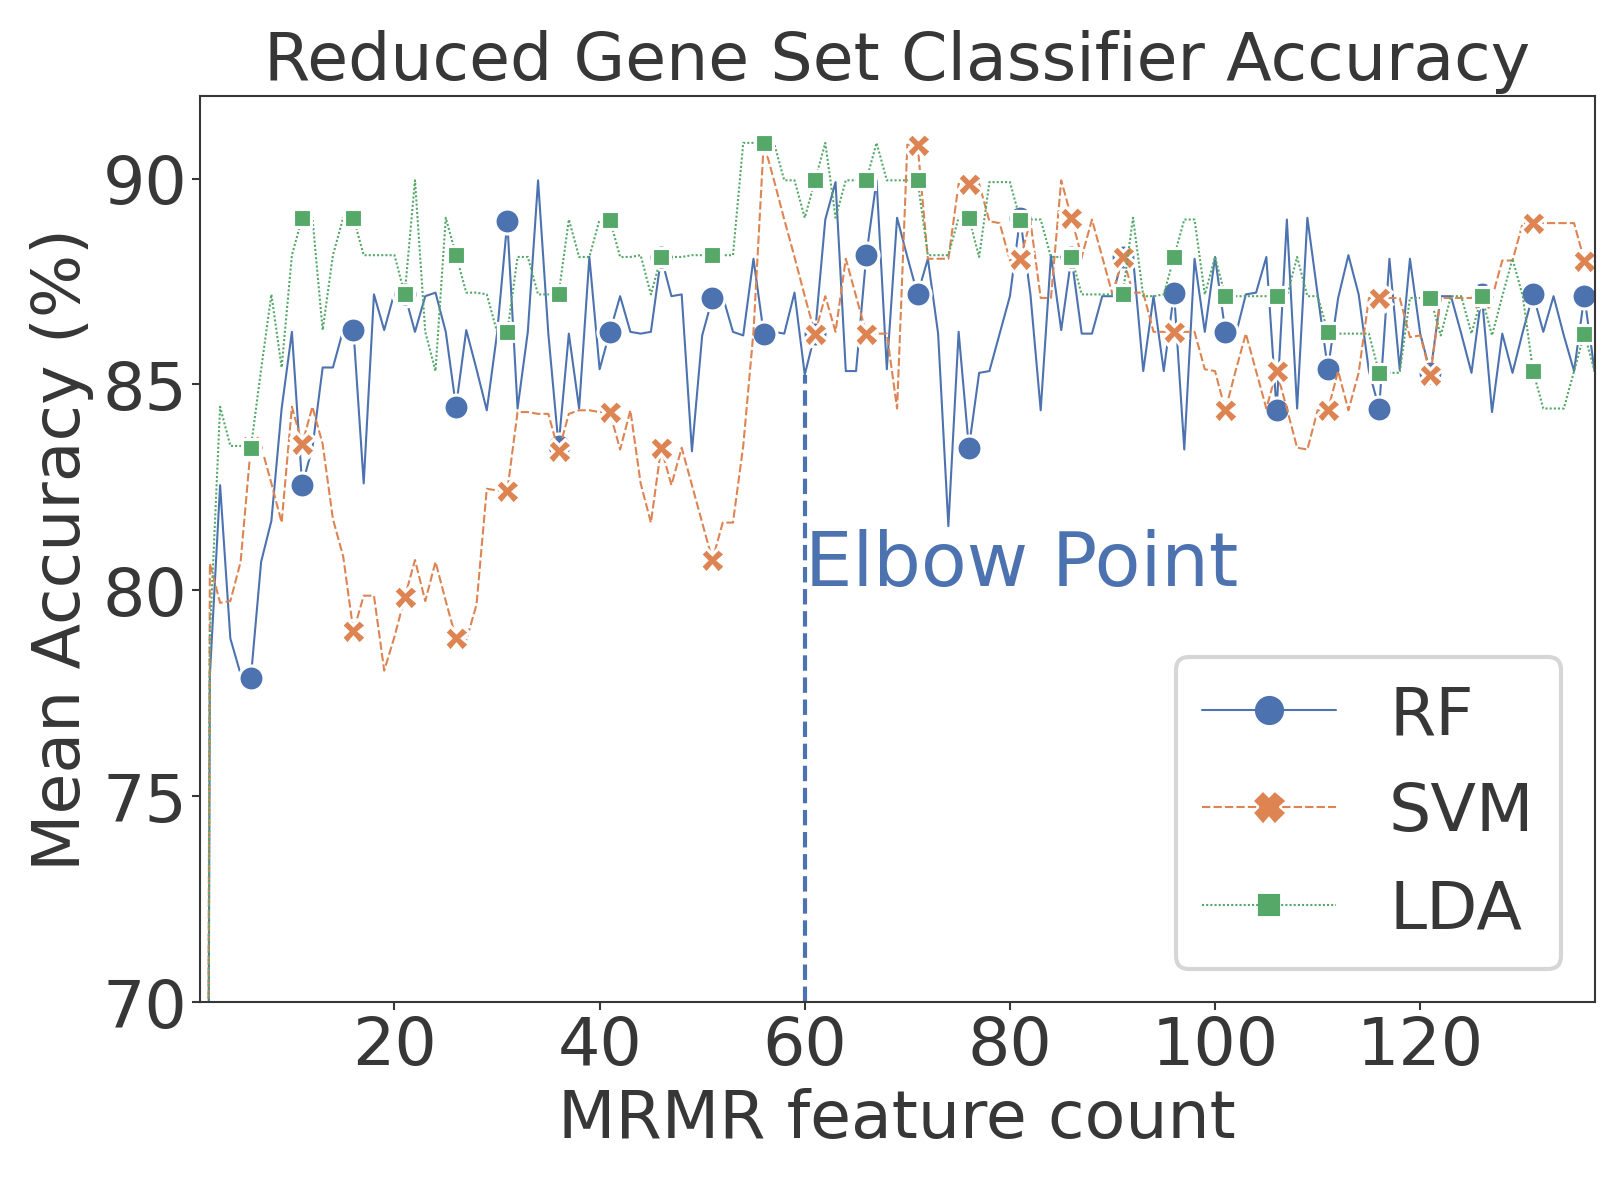

In [13]:
## figure notes: The order of MRMR features included is based on the order that the feature selection was done at each iteration. 
## The average test set accuracy is determined using the accuracy in each of the folds
# include annotation at every ~10th data point

accuracy_plot(wide_df[rf_svm_lda_mask], add_label=False, elbow=60, right=137)

In [14]:
if generate_flat_files:
    pd.read_csv('./data/mrmr/mrmr_200.csv', index_col=0).head(60).to_csv("./data/mrmr/mrmr_60.csv", header=True)

### Generating Visualizations (PCA)

[Return to Navigation](#Navigation-Links-Throughout-Analysis)

The following code block is used to generate PCA plots for various transforms of the data. Within the `RNASeqModel.py` file, the `scale` parameter of the `load_counts` function can be changed to enable or disable Z-score standardization.

Please see the comment with additional runtime configurations, which will subset the feature subset to prefiltered genes, mrmr genes, etc.

Loaded files: 168_rr1.csv,168_rr3.csv,242.csv,245.csv,379.csv,47.csv
Loaded files: 168_rr1.txt,168_rr3.txt,242.txt,245.txt,379.txt,47.txt
Removed following counts: 
Order that counts are concatenated: dict_keys(['168_rr1', '168_rr3', '242', '245', '379', '47'])
(137, 17773)
['M', 'F']
Models chosen are:  []
Done.


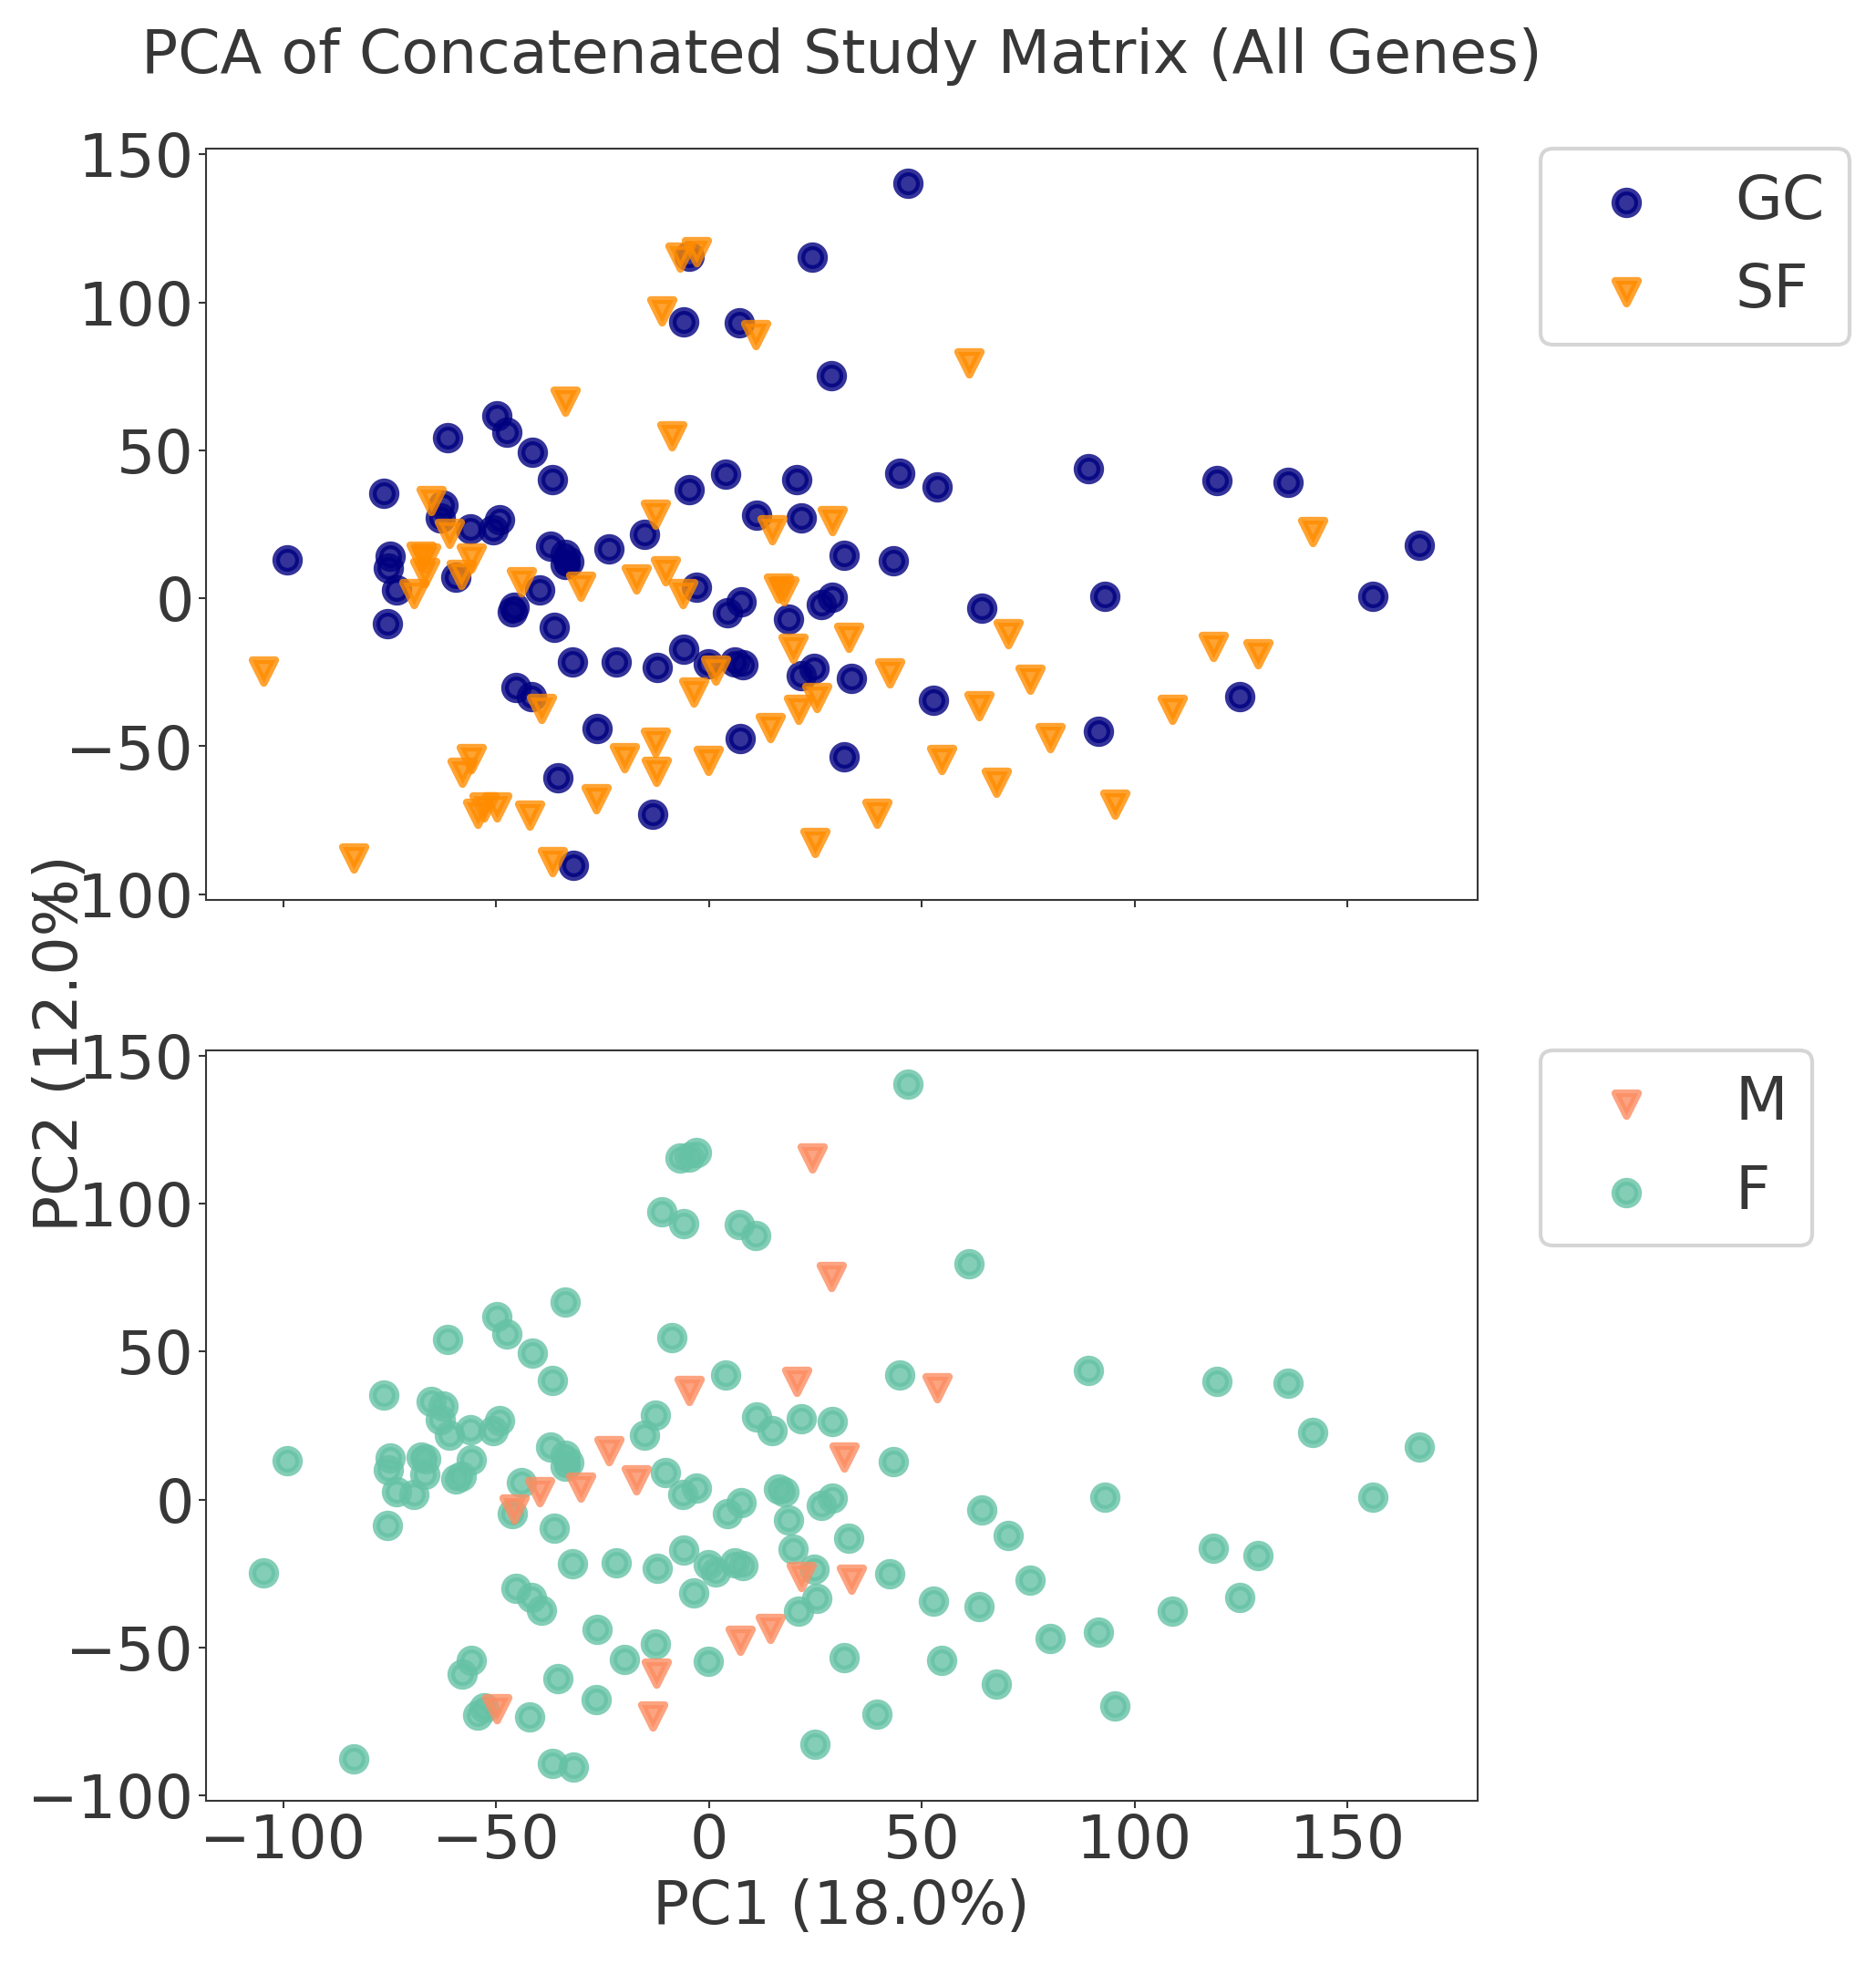

In [15]:
# all genes
%run RNASeqModel.py --block_flags ./data/run_flags/pca_run.json
# for prefiltered genes only, add: --feature_list ./data/prefiltering/prefiltered_pseudogenes.csv
# for mrmr only, add: --gene_list ./data/mrmr/mrmr_60.csv

plt.show()

### Classifers trained using Random Selection from All Non-Pseudogenes (Still Prefiltered)

[Return to Navigation](#Navigation-Links-Throughout-Analysis)

The following code block is used as a reference baseline to demonstrate the above analysis for a random set of features instead of mRMR selected features.

In [16]:
%run RNASeqModel.py --feature_list ./data/prefiltering/prefiltered_pseudogenes.csv --block_flags ./data/run_flags/all_genes_all_models.json

Loaded files: 168_rr1.csv,168_rr3.csv,242.csv,245.csv,379.csv,47.csv
Loaded files: 168_rr1.txt,168_rr3.txt,242.txt,245.txt,379.txt,47.txt
Removed following counts: 
Order that counts are concatenated: dict_keys(['168_rr1', '168_rr3', '242', '245', '379', '47'])
(137, 17773)
Random gene IDs [13651, 333, 9785, 12072, 6345]
Models chosen are:  ['rf', 'svm', 'lda']
Done.


Accessing the results dictionary for the accuracy results dataframe.

In [17]:
# %run RNASeqModel.py --block_flags ./data/run_flags/model_test_accuracy.json
print(results['rf']['accuracy'].loc[0])
print(results['svm']['accuracy'].loc[0])
print(results['lda']['accuracy'].loc[0])

Accuracy    0.655172
Name: 0, dtype: float64
Accuracy    0.586207
Name: 0, dtype: float64
Accuracy    0.655172
Name: 0, dtype: float64


The following code block shows the receiver operator characteristic (ROC) curve that was generated from a random set of features.

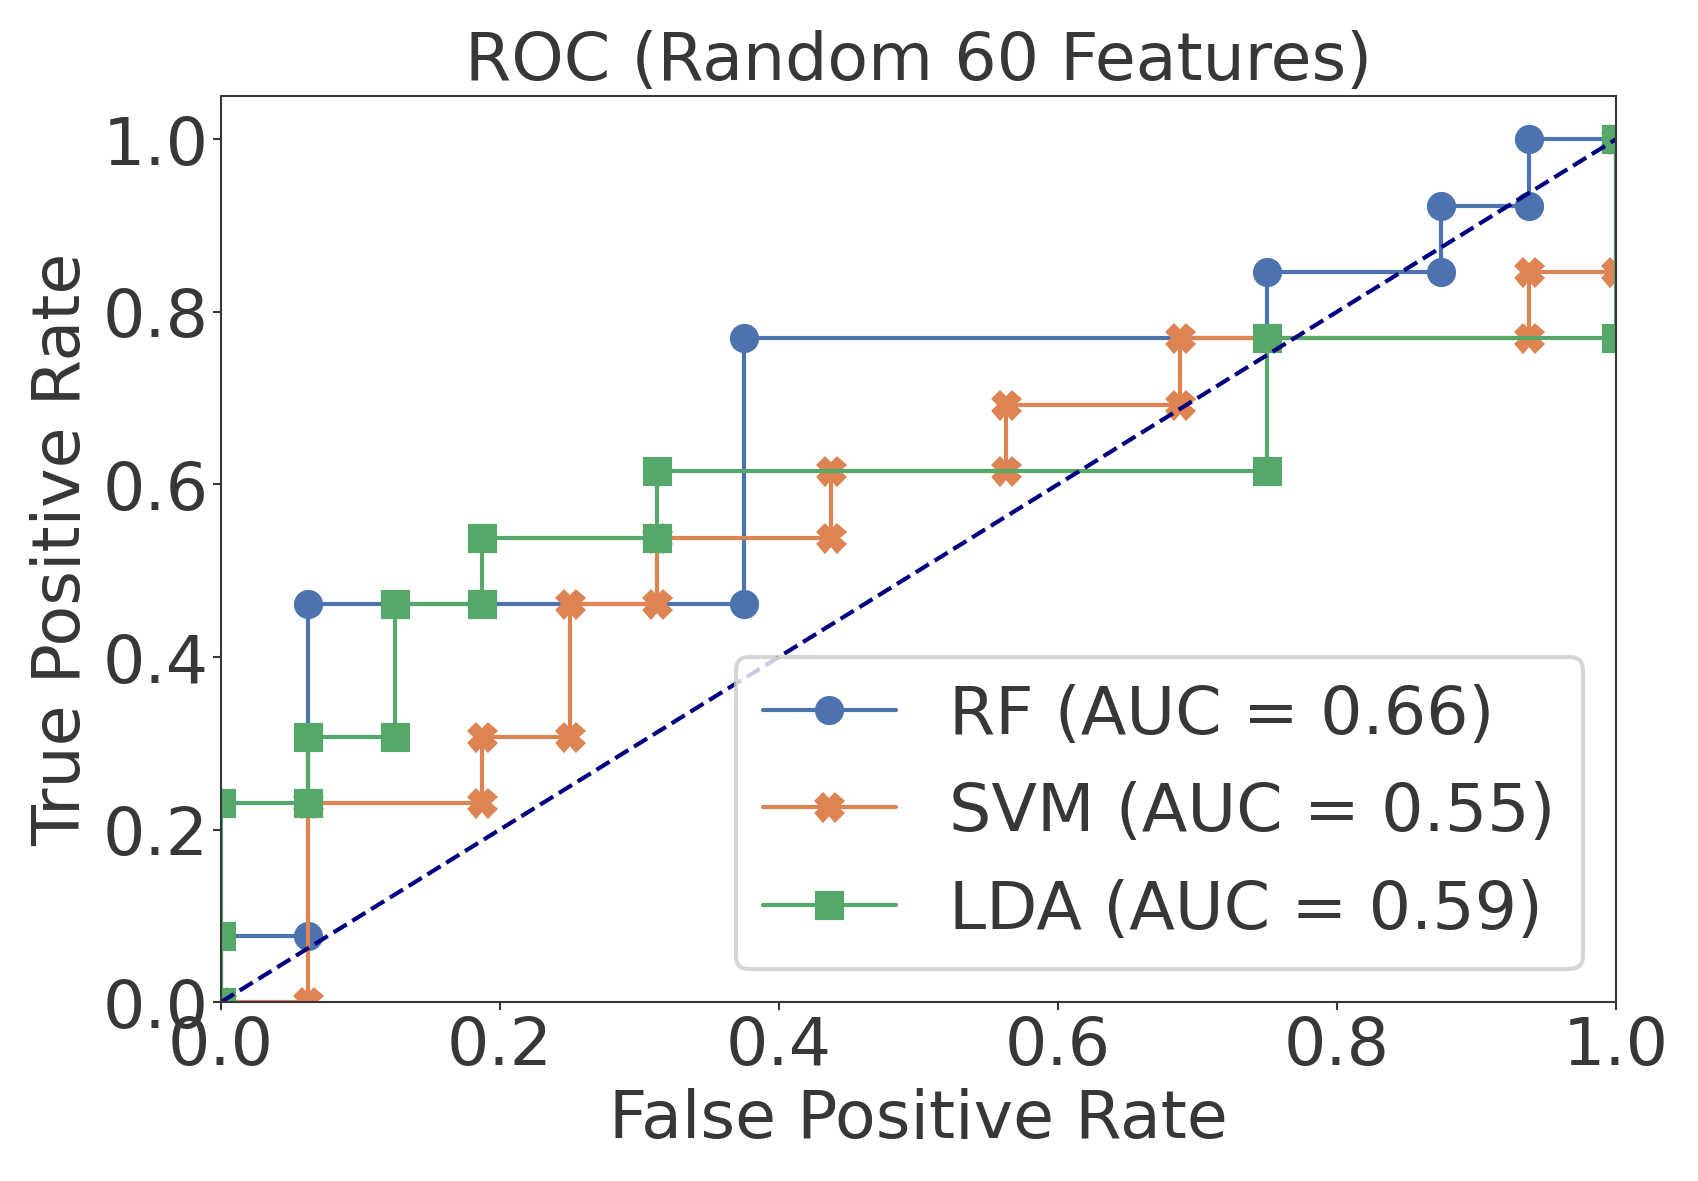

In [18]:
roc_plot({
    'rf':results['rf']['roc'], 
    'svm':results['svm']['roc'], 
    'lda':results['lda']['roc']
    },
    title='ROC (Random 60 Features)'
)

The saved receiver operator characteristic curves can be used to replicate the pROC test results (using DeLong's method).

In [19]:
results['rf']['predictions']['model'] = 'rf'
results['svm']['predictions']['model'] = 'svm'
results['lda']['predictions']['model'] = 'lda'
random_df = pd.concat([results[m]['predictions'] for m in ['rf', 'svm', 'lda']])
if generate_flat_files:
    random_df.to_csv('data/roc_results/predictions_random.csv')

### Classifiers trained using top MRMR Genes per Elbow Point

[Return to Navigation](#Navigation-Links-Throughout-Analysis)

The following code block trains the ML classfiers using the mRMR selected features instead of the random baseline. 

Here we make a subset of the `mrmr_200.csv` file that only contains the top 60 features. We call this file `mrmr_60.csv`.

In [20]:
%run RNASeqModel.py --feature_list ./data/prefiltering/prefiltered_pseudogenes.csv --gene_list ./data/mrmr/mrmr_60.csv --block_flags ./data/run_flags/mrmr_genes_all_models.json

Loaded files: 168_rr1.csv,168_rr3.csv,242.csv,245.csv,379.csv,47.csv
Loaded files: 168_rr1.txt,168_rr3.txt,242.txt,245.txt,379.txt,47.txt
Removed following counts: 
Order that counts are concatenated: dict_keys(['168_rr1', '168_rr3', '242', '245', '379', '47'])
(137, 17773)
Models chosen are:  ['rf', 'svm', 'lda']
Done.


<Figure size 1400x1000 with 0 Axes>

The following code block shows the receiver operator characteristic (ROC) curve that was generated from an mRMR selected set of features.

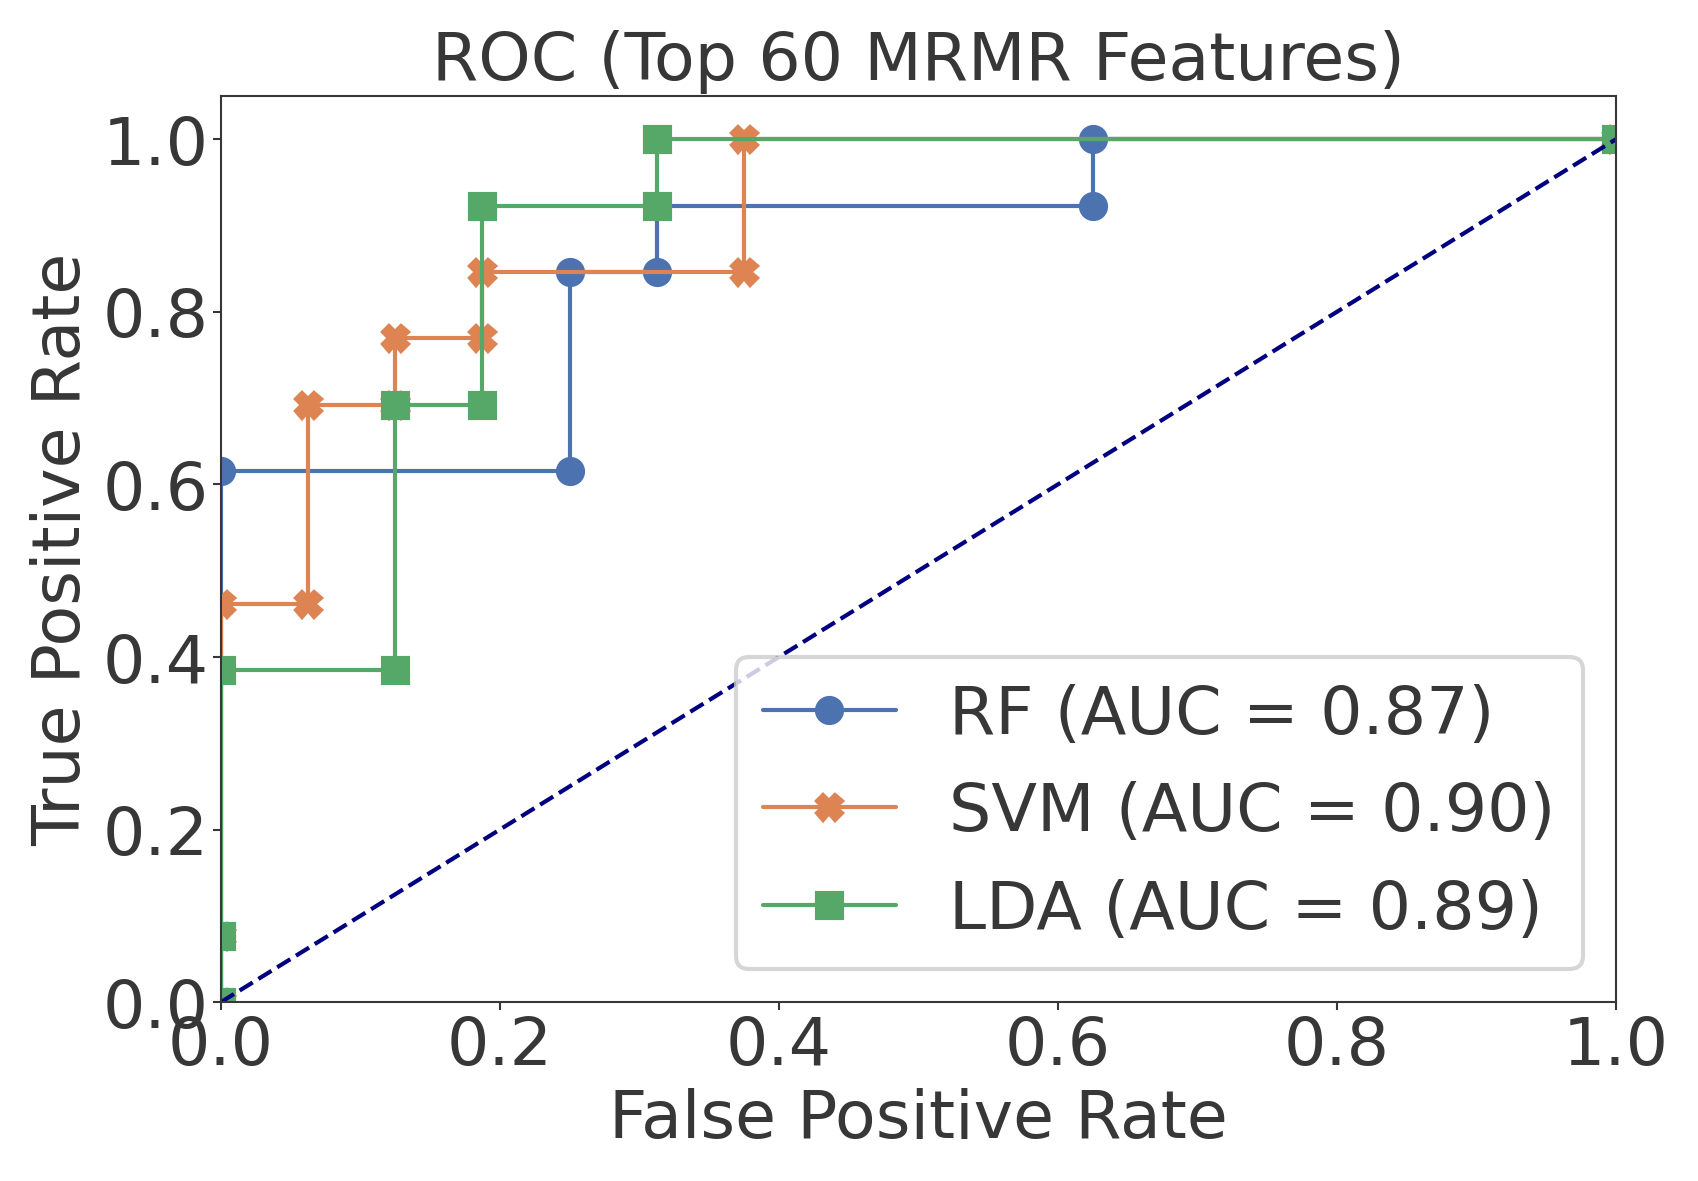

In [21]:
roc_plot({
    'rf':results['rf']['roc'], 
    'svm':results['svm']['roc'], 
    'lda':results['lda']['roc']
    },
    title='ROC (Top 60 MRMR Features)'
)

In [22]:
results['rf']['predictions']['model'] = 'rf'
results['svm']['predictions']['model'] = 'svm'
results['lda']['predictions']['model'] = 'lda'
mrmr_df = pd.concat([results[m]['predictions'] for m in ['rf', 'svm', 'lda']])

In [23]:
if generate_flat_files:
    mrmr_df.to_csv('data/roc_results/predictions_mrmr.csv')

### Cluster Map

[Return to Navigation](#Navigation-Links-Throughout-Analysis)

The following code is used to generate the clustermap used in the manuscript. The subset of features are the mRMR selected subset.

In [24]:
%run RNASeqModel.py --feature_list ./data/prefiltering/prefiltered_pseudogenes.csv --gene_list ./data/mrmr/mrmr_60.csv --block_flags ./data/run_flags/mrmr_genes_raw.json

Loaded files: 168_rr1.csv,168_rr3.csv,242.csv,245.csv,379.csv,47.csv
Loaded files: 168_rr1.txt,168_rr3.txt,242.txt,245.txt,379.txt,47.txt
Removed following counts: 
Order that counts are concatenated: dict_keys(['168_rr1', '168_rr3', '242', '245', '379', '47'])
(137, 17773)
Models chosen are:  []
Done.


<Figure size 1400x1000 with 0 Axes>

In [27]:
study_cols = {'RR1(N)':'#EF476F', 'RR3':'#F78C6B', 'RR1(C)':'#FFD166','RR9':'#06D6A0','RR6':'#118AB2','RR8':'#073B4C'}
age_col_cols = {'10-12':'#767656', '16':'#C7BC6B', '32':'#EFEBCE'}
age_cols = {'RR1(N)':age_col_cols['16'], 'RR3':age_col_cols['10-12'], 'RR1(C)':age_col_cols['32'],'RR9':age_col_cols['10-12'],'RR6':age_col_cols['32'],'RR8':age_col_cols['10-12']}


target_cols = {'SF':'#000000', 'GC':'#C4C4C4'}

In [28]:
RR1_N = dict(zip(model.count_dict['168_rr1']['counts'].index.values, [study_cols['RR1(N)']]*len(model.count_dict['168_rr1']['counts'].index.values)))
RR3 = dict(zip(model.count_dict['168_rr3']['counts'].index.values, [study_cols['RR3']]*len(model.count_dict['168_rr3']['counts'].index.values)))
RR1_C = dict(zip(model.count_dict['47']['counts'].index.values, [study_cols['RR1(C)']]*len(model.count_dict['47']['counts'].index.values)))
RR9 = dict(zip(model.count_dict['242']['counts'].index.values, [study_cols['RR9']]*len(model.count_dict['242']['counts'].index.values)))
RR6 = dict(zip(model.count_dict['245']['counts'].index.values, [study_cols['RR6']]*len(model.count_dict['245']['counts'].index.values)))
RR8 = dict(zip(model.count_dict['379']['counts'].index.values, [study_cols['RR8']]*len(model.count_dict['379']['counts'].index.values)))
study_dict = {**RR1_N, **RR3, **RR1_C, **RR9, **RR6, **RR8}
study_map = pd.Series(model.concat_df.index.map(study_dict), index=model.concat_df.index, name='Study')

In [29]:
RR1_N = dict(zip(model.count_dict['168_rr1']['counts'].index.values, [age_cols['RR1(N)']]*len(model.count_dict['168_rr1']['counts'].index.values)))
RR3 = dict(zip(model.count_dict['168_rr3']['counts'].index.values, [age_cols['RR3']]*len(model.count_dict['168_rr3']['counts'].index.values)))
RR1_C = dict(zip(model.count_dict['47']['counts'].index.values, [age_cols['RR1(C)']]*len(model.count_dict['47']['counts'].index.values)))
RR9 = dict(zip(model.count_dict['242']['counts'].index.values, [age_cols['RR9']]*len(model.count_dict['242']['counts'].index.values)))
RR6 = dict(zip(model.count_dict['245']['counts'].index.values, [age_cols['RR6']]*len(model.count_dict['245']['counts'].index.values)))
RR8 = dict(zip(model.count_dict['379']['counts'].index.values, [age_cols['RR8']]*len(model.count_dict['379']['counts'].index.values)))
RR8 = {k:age_col_cols['32'] if 'OLD' in k else v for k,v in RR8.items()}
study_dict = {**RR1_N, **RR3, **RR1_C, **RR9, **RR6, **RR8}
age_map = pd.Series(model.concat_df.index.map(study_dict), index=model.concat_df.index, name='Age')

In [30]:
RR1_N = dict(zip(model.count_dict['168_rr1']['counts'].index.values, ['RR1(N)']*len(model.count_dict['168_rr1']['counts'].index.values)))
RR3 = dict(zip(model.count_dict['168_rr3']['counts'].index.values, ['RR3']*len(model.count_dict['168_rr3']['counts'].index.values)))
RR1_C = dict(zip(model.count_dict['47']['counts'].index.values, ['RR1(C)']*len(model.count_dict['47']['counts'].index.values)))
RR9 = dict(zip(model.count_dict['242']['counts'].index.values, ['RR9']*len(model.count_dict['242']['counts'].index.values)))
RR6 = dict(zip(model.count_dict['245']['counts'].index.values, ['RR6']*len(model.count_dict['245']['counts'].index.values)))
RR8 = dict(zip(model.count_dict['379']['counts'].index.values, ['RR8']*len(model.count_dict['379']['counts'].index.values)))
study_dict = {**RR1_N, **RR3, **RR1_C, **RR9, **RR6, **RR8}
ylabel_from_map = pd.Series(model.concat_df.index.map(study_dict), index=model.concat_df.index, name='Group')

Text(0.5, 179.61111111111111, 'MRMR Feature (Rank)')

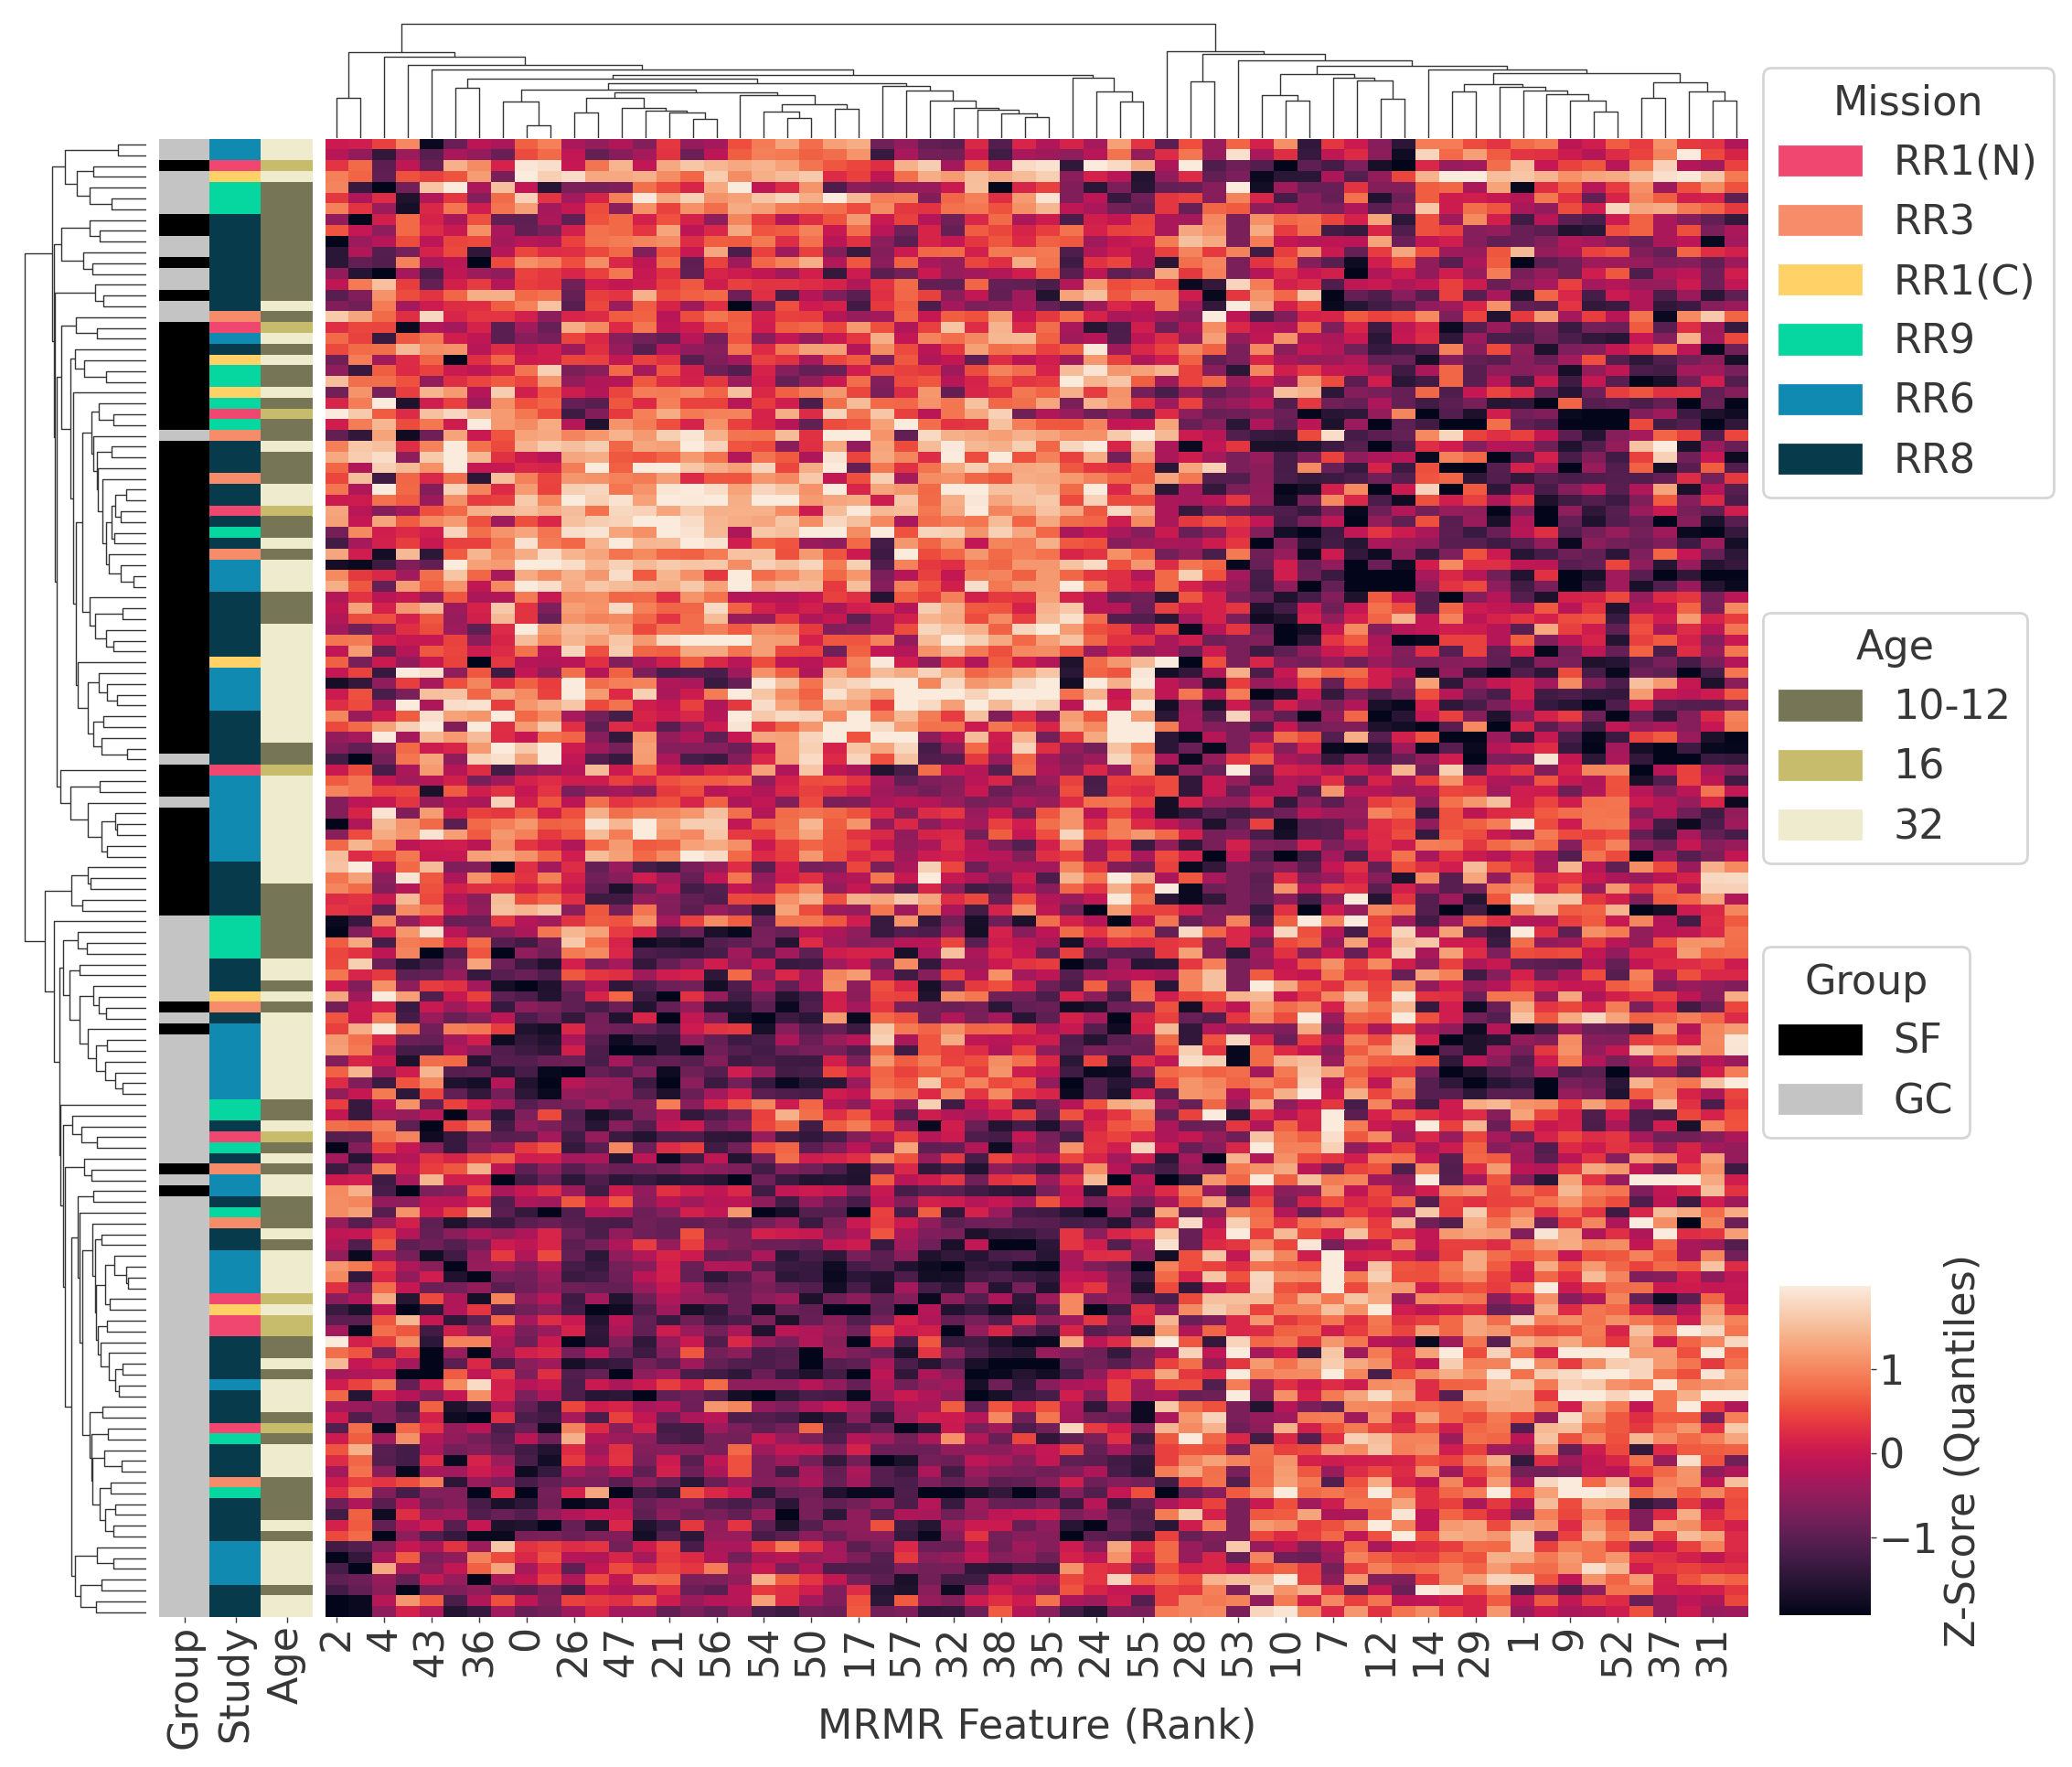

In [31]:
# fig, ax = plt.subplots(figsize=(6,8), dpi=300)
lut = dict(zip(model.concat_df.iloc[:,-1].unique(), target_cols.values()))
row_colors = model.concat_df.iloc[:,-1].map(lut)
row_colors.name = 'Group'
# model.concat_df.loc[:,model.Genes['Gene']]
cluster_df = model.concat_df.copy()
cluster_df = cluster_df.loc[:,model.Genes['Gene']]
cluster_df.columns = np.arange(model.Genes['Gene'].shape[0])

cmap = sns.clustermap(
    cluster_df, 
    row_colors=pd.concat([row_colors,study_map, age_map],axis=1), 
    metric='correlation', 
    row_cluster=True, 
    col_cluster=True, 
    dendrogram_ratio=0.075, 
    yticklabels=False,
    xticklabels=2,
    cbar_pos=(0.99, 0.1, 0.05, 0.18),
    cbar_kws={'label':'Z-Score (Quantiles)'}, shading='flat', snap=True, robust=True
)
import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='red', label='The red data')
cmap.figure.legend(handles=[mpatches.Patch(color=v, label=k) for k,v in study_cols.items()], bbox_to_anchor=(0.97, 0.70, 0.05, 0.18), loc='lower left', title='Mission')
cmap.figure.legend(handles=[mpatches.Patch(color=v, label=k) for k,v in target_cols.items()], bbox_to_anchor=(0.97, 0.35, 0.05, 0.18), loc='lower left', title='Group')
cmap.figure.legend(handles=[mpatches.Patch(color=v, label=k) for k,v in age_col_cols.items()], bbox_to_anchor=(0.97, 0.50, 0.05, 0.18), loc='lower left', title='Age')
cmap.ax_heatmap.set_xlabel('MRMR Feature (Rank)', labelpad=12.0)

### Generating Coefficients-based importances from baseline model training

[Return to Navigation](#Navigation-Links-Throughout-Analysis)

The following code block is used to get the linear kernel coefficients from the trained support vector machine model.

In [32]:
%run RNASeqModel.py --feature_list ./data/prefiltering/prefiltered_pseudogenes.csv --block_flags ./data/run_flags/svm_baseline.json
svm_mrmr_results = results
if generate_flat_files:
    results['svm']['model_coefs'].to_csv('./data/coefficient_results/svm_importances.csv', header=True)

Loaded files: 168_rr1.csv,168_rr3.csv,242.csv,245.csv,379.csv,47.csv
Loaded files: 168_rr1.txt,168_rr3.txt,242.txt,245.txt,379.txt,47.txt
Removed following counts: 
Order that counts are concatenated: dict_keys(['168_rr1', '168_rr3', '242', '245', '379', '47'])
(137, 17773)
Models chosen are:  ['svm']
Done.


<Figure size 1400x1000 with 0 Axes>

The `R Mouse Liver Manuscript.pynb` notebook will be needed to generate the DESeq2 GO Terms

In [33]:
go_names = ['168_RR1','242','245', '379'] # 47, 168_RR3
cat_names = ['(NASA) RR1', 'RR9', 'RR6', 'RR8'] # (CASIS RR1), RR3
go_dfs = {f:pd.read_table(f'./data/single_study_go_terms/GLDS-{f}-GO.tsv') for f in go_names}
go_names.append('SVM'); cat_names.append('SVM')
go_dfs['SVM'] = pd.read_table(f'./data/combined_study_go_terms/svm_coeff_gseGO.tsv')
go_dfs['SVM']['ONTOLOGY'] = 'BP'

In [34]:
studies = from_contents({cat:go_dfs[dset].loc[:,'ID'] for cat, dset in zip(cat_names, go_names)})

In [35]:
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['xtick.labelsize'] = 18
mpl.rcParams['ytick.labelsize'] = 18

{'matrix': <AxesSubplot:>,
 'shading': <AxesSubplot:>,
 'totals': <AxesSubplot:>,
 'intersections': <AxesSubplot:ylabel='Intersection size'>}

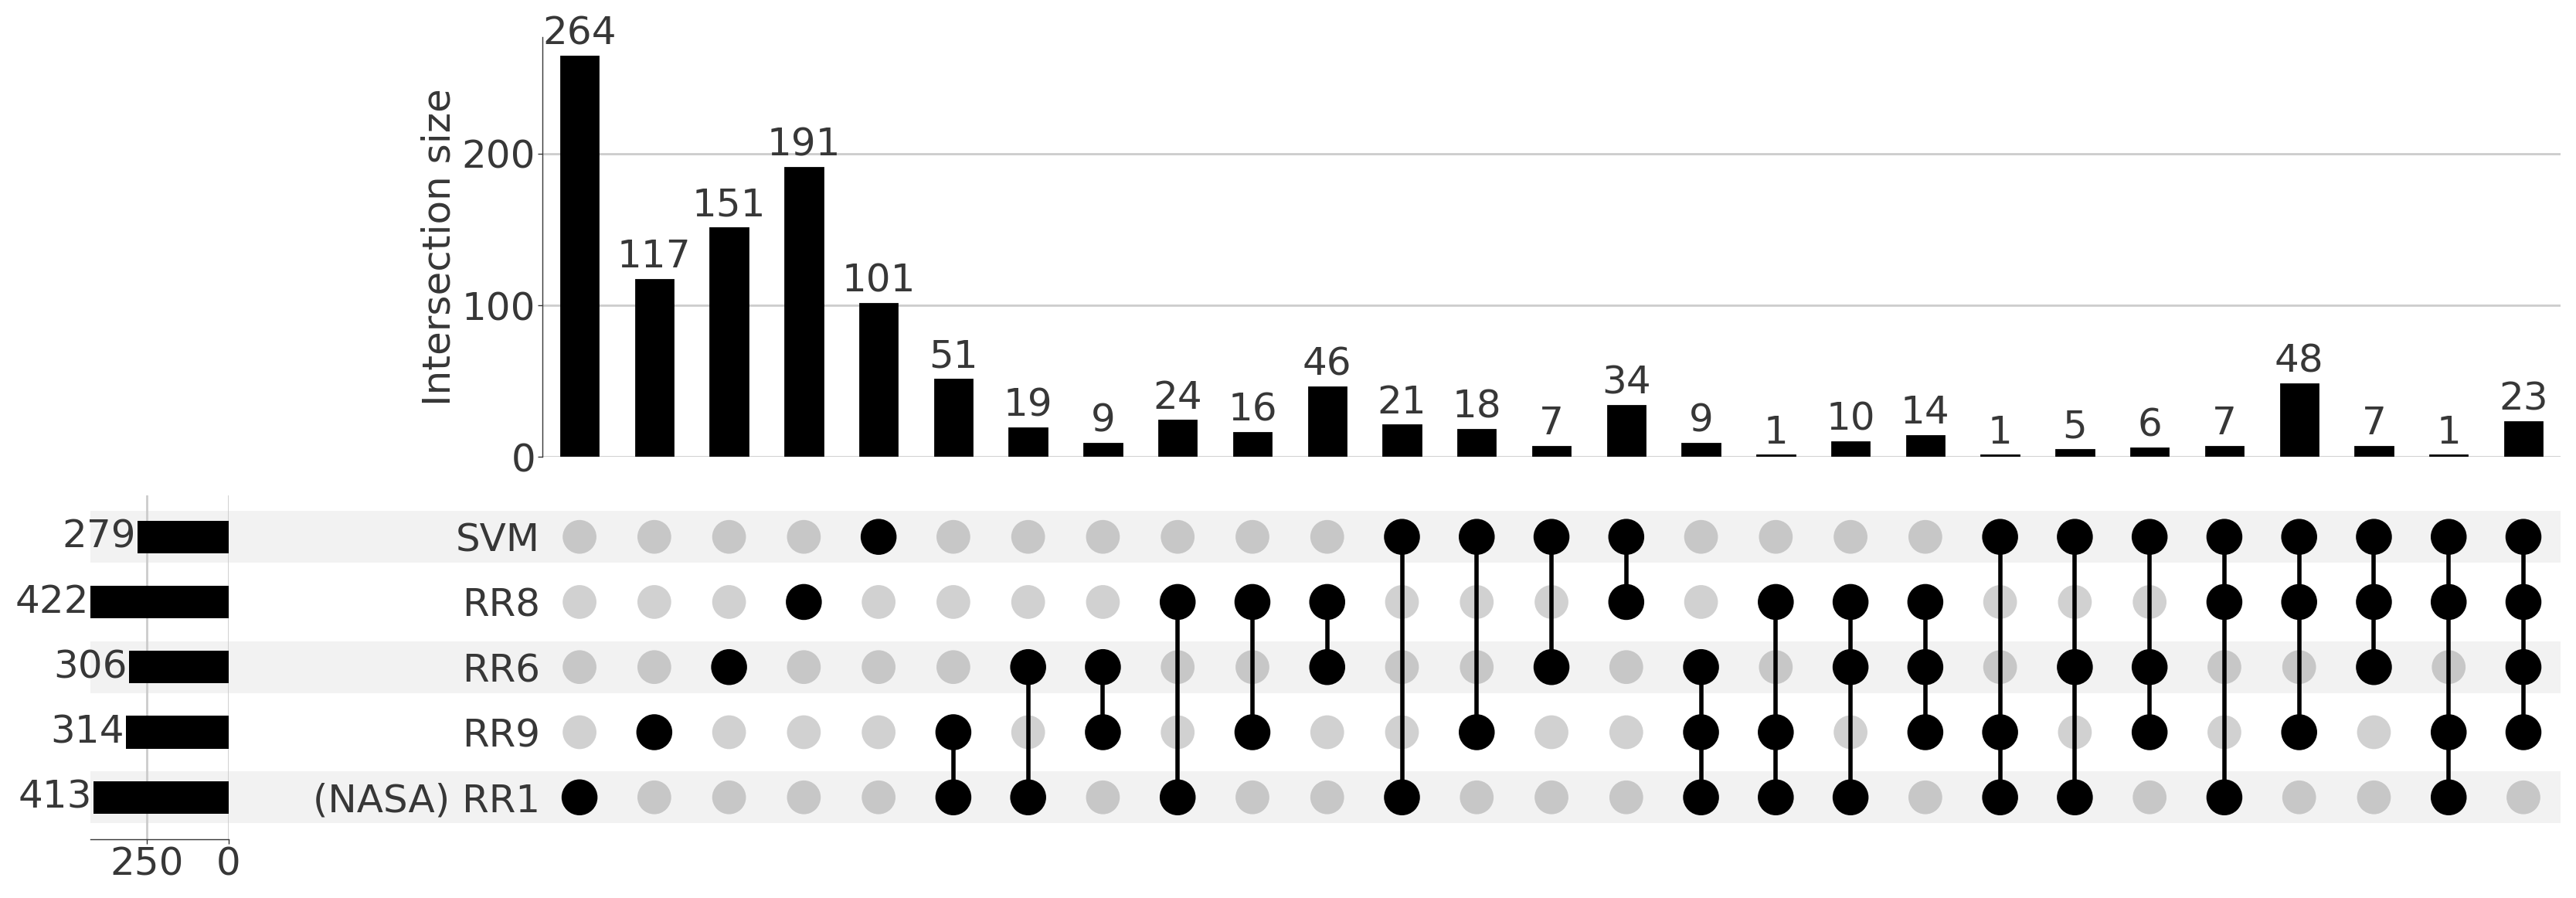

In [36]:
plt = UpSet(studies, subset_size='count', sort_categories_by='input', show_counts=True, element_size=45)
plt.plot()

### Permutation Feature Importance on All Models

[Return to Navigation](#Navigation-Links-Throughout-Analysis)

The following code block is used to execute permutation feature importance generation from the mRMR feature subset.

In [37]:
%run RNASeqModel.py --feature_list ./data/prefiltering/prefiltered_pseudogenes.csv --gene_list ./data/mrmr/mrmr_60.csv --block_flags ./data/run_flags/pfi_mrmr_all_models.json

Loaded files: 168_rr1.csv,168_rr3.csv,242.csv,245.csv,379.csv,47.csv
Loaded files: 168_rr1.txt,168_rr3.txt,242.txt,245.txt,379.txt,47.txt
Removed following counts: 
Order that counts are concatenated: dict_keys(['168_rr1', '168_rr3', '242', '245', '379', '47'])
(137, 17773)
Models chosen are:  ['rf', 'svm', 'lda']
Done.


<Figure size 1400x1000 with 0 Axes>

In [38]:
fname_end = ''
path_name = './data/importance_results/'
results['rf']['importance'].to_csv(f'{path_name}rf_importances{fname_end}.csv'); results['svm']['importance'].to_csv(f'{path_name}svm_mrmr_importances{fname_end}.csv'); results['lda']['importance'].to_csv(f'{path_name}lda_importances{fname_end}.csv'); 

In [39]:
mrmr_gene_ranking = pd.read_csv("./data/mrmr/mrmr_60.csv", index_col=0)
svm_importances = pd.read_csv("./data/importance_results/svm_mrmr_importances.csv", index_col=0); lda_importances = pd.read_csv("./data/importance_results/lda_importances.csv", index_col=0); rf_importances = pd.read_csv("./data/importance_results/rf_importances.csv", index_col=0);
svm_importances_ranking, svm_importances_ordered_by_ranking = generate_ranking_from_permutation_importance(svm_importances);
lda_importances_ranking, lda_importances_ordered_by_ranking = generate_ranking_from_permutation_importance(lda_importances); 
rf_importances_ranking, rf_importances_ordered_by_ranking = generate_ranking_from_permutation_importance(rf_importances)
mrmr_gene_ranking['mrmr'] = np.arange(60); mrmr_gene_ranking['svm'] = svm_importances_ranking - 1; mrmr_gene_ranking['lda'] = lda_importances_ranking - 1; mrmr_gene_ranking['rf'] = rf_importances_ranking - 1

In [40]:
melted_ranking = mrmr_gene_ranking.melt(id_vars=['Gene'])
melted_ranking.columns = ['Gene', "model", 'rank']

order, levels = pd.factorize(melted_ranking['model'])
melted_ranking['order'] = order

# Generation of Box Plots for Rank Comparisons Between Methods

[Return to Navigation](#Navigation-Links-Throughout-Analysis)

The following code block is used to generate a set of box plots based on feature importance ranking of the mRMR feature subset.

In [41]:
boxplot_xticks = []
boxplot_yticks = []
for v in np.arange(60)+1:
    if v % 2 == 0:
        boxplot_xticks.append(str(v))
    else:
        boxplot_xticks.append('')
    if v == 1:
        boxplot_yticks.append(str(v))
    elif v % 15 == 0:
        boxplot_yticks.append(str(v))
    else:
        boxplot_yticks.append('')

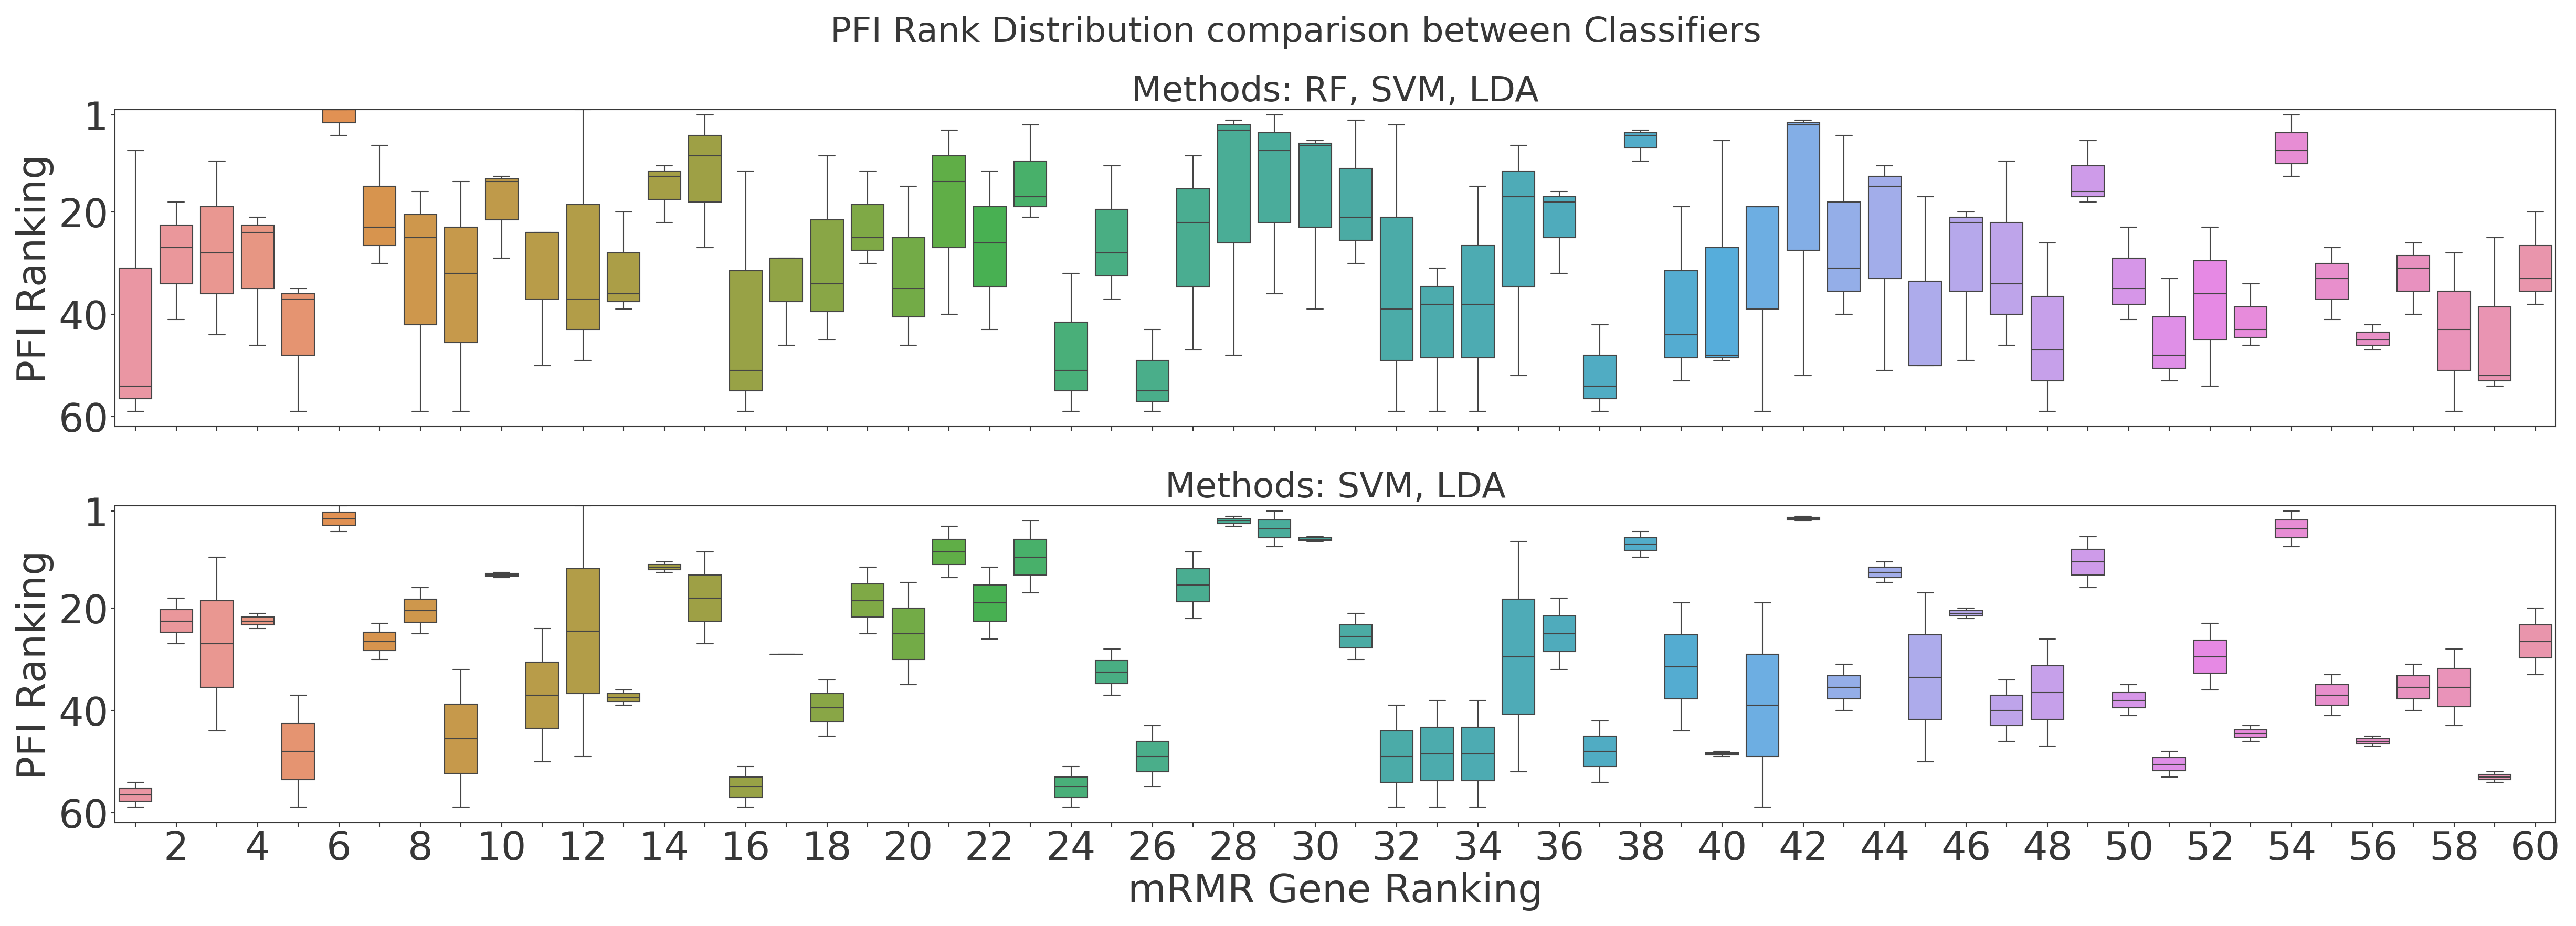

In [42]:
lda_svm_ind = 1
rf_lda_svm_ind = 0
fig, ax = plt.subplots(figsize=(20,6), dpi=300, nrows=2, ncols=1, sharex=True)
sns.boxplot(data=melted_ranking[melted_ranking['model'].isin(['lda','svm'])], x="Gene", y="rank", order=melted_ranking[melted_ranking['model'] == 'mrmr']['Gene'].values, ax=ax[lda_svm_ind])
sns.boxplot(data=melted_ranking[melted_ranking['model'].isin(['rf','lda','svm'])], x="Gene", y="rank", order=melted_ranking[melted_ranking['model'] == 'mrmr']['Gene'].values, ax=ax[rf_lda_svm_ind])

ax[rf_lda_svm_ind].set_ylim(bottom=0)
ax[lda_svm_ind].set_ylim(bottom=0)

tick_list = [1,20,40,60]
ax[rf_lda_svm_ind].set_yticks(tick_list)
ax[lda_svm_ind].set_yticks(tick_list)

ax[rf_lda_svm_ind].set_yticklabels([str(v) for v in tick_list])
ax[lda_svm_ind].set_yticklabels([str(v) for v in tick_list])

ax[rf_lda_svm_ind].set_xticklabels(boxplot_xticks)
ax[lda_svm_ind].set_xticklabels(boxplot_xticks)
ax[lda_svm_ind].set_xlabel("mRMR Gene Ranking")
ax[rf_lda_svm_ind].set_xlabel("")
ax[rf_lda_svm_ind].set_ylabel("PFI Ranking")
ax[lda_svm_ind].set_ylabel("PFI Ranking")

ax[lda_svm_ind].set_title("Methods: SVM, LDA")
ax[rf_lda_svm_ind].set_title("Methods: RF, SVM, LDA")

ax[lda_svm_ind].invert_yaxis()
ax[rf_lda_svm_ind].invert_yaxis()

fig.suptitle('PFI Rank Distribution comparison between Classifiers', fontsize=16)

plt.subplots_adjust(hspace=0.25)

# mRMR Pairwise Correlation Cluster Analysis

[Return to Navigation](#Navigation-Links-Throughout-Analysis)

The following code block is used to get correlations between mRMR features and all prefiltered pseudogenes. This is used to re-generate correlated clusters for each mRMR selected feature.

In [43]:
%run RNASeqModel.py --feature_list ./data/prefiltering/prefiltered_pseudogenes.csv --block_flags ./data/run_flags/base_run.json

Loaded files: 168_rr1.csv,168_rr3.csv,242.csv,245.csv,379.csv,47.csv
Loaded files: 168_rr1.txt,168_rr3.txt,242.txt,245.txt,379.txt,47.txt
Removed following counts: 
Order that counts are concatenated: dict_keys(['168_rr1', '168_rr3', '242', '245', '379', '47'])
(137, 17773)
Models chosen are:  []
Done.


<Figure size 1400x1000 with 0 Axes>

In [44]:
pairwise_corr = model.concat_df.corr()

In [45]:
ranked_correlations = pairwise_corr.apply(lambda x: x.abs().argsort(), axis=1)

Identifying the correct hyperparameter based off ppar$\alpha$

In [46]:
# ENSEMBL ID for ppara
gene = 'ENSMUSG00000038393'
sorted_corrs = pairwise_corr.iloc[np.where(pairwise_corr.index.values == gene)[0][0], ranked_correlations.loc[gene,:].values]

Looking at case for ppar$\alpha$, which is known to influence Txnip (ENSMUSG00000038393)

In [47]:
# The correlation threshold cutoff was based on this (250 nearest features)
np.where(sorted_corrs.index.values == 'ENSMUSG00000038393')[0] - np.where(sorted_corrs.index.values == 'ENSMUSG00000022383')[0]

array([246])

In [48]:
# here is a dictionary with the top 250 correlated genes to each MRMR gene
top_corr_dict = {}
for g in mrmr_gene_ranking['Gene']:
    sorted_corrs = pairwise_corr.iloc[np.where(pairwise_corr.index.values == g)[0][0], ranked_correlations.loc[g,:].values]
    top_corr_dict[g] = sorted_corrs.tail(250)

### Comparison of MRMR Genes to Liver Genes of Interest

[Return to Navigation](#Navigation-Links-Throughout-Analysis)

The following code block compares the genes identified in the correlation analysis back to the gene signature set identified from background research.

In [49]:
# liver gene list of interest
liver_gene_list = ['ENSMUSG00000022383', 'ENSMUSG00000002250', 'ENSMUSG00000000440', #ppar-alpha
                   'ENSMUSG00000023067', #cdkn1a
                   'ENSMUSG00000040383', 'ENSMUSG00000020810', 'ENSMUSG00000040170', 'ENSMUSG00000004341', 'ENSMUSG00000018893', 'ENSMUSG00000031257', 'ENSMUSG00000028328', 'ENSMUSG00000032942', 'ENSMUSG00000025950', 'ENSMUSG00000030562', 'ENSMUSG00000037071', 'ENSMUSG00000051029', #oxidative stress
                  'ENSMUSG00000032315', 'ENSMUSG00000032310', 'ENSMUSG00000029455', 'ENSMUSG00000025197', 'ENSMUSG00000025479'] #CYP


In [50]:
liver_gene_hits = {}
for g in liver_gene_list:
    hit_list = []
    for mrmr_gene in top_corr_dict.keys():
        if np.isin(g, top_corr_dict[mrmr_gene].index.values):
            hit_list.append(mrmr_gene)
    liver_gene_hits[g] = hit_list

In [51]:
top_svm_lda_rf = ['ENSMUSG00000086669', 'ENSMUSG00000033781', 'ENSMUSG00000051969', 'ENSMUSG00000046962', 'ENSMUSG00000035493']
top_svm_lda = ['ENSMUSG00000066319', 'ENSMUSG00000050232', 'ENSMUSG00000069920', 'ENSMUSG00000036752', 'ENSMUSG00000035493']
top_all_mrmr = ['ENSMUSG00000033781', 'ENSMUSG00000046962', 'ENSMUSG00000032026', 'ENSMUSG00000035493', 'ENSMUSG00000042215']

In [52]:
for g in liver_gene_hits.keys():
    for h in liver_gene_hits[g]:
        if np.isin(h, top_svm_lda_rf):
            print('MRMR gene {} is correlated with liver interest gene {} in the SVM + LDA + RF case'.format(h, g))
        if np.isin(h, top_svm_lda):
            print('MRMR gene {} is correlated with liver interest gene {} in the SVM + LDA case'.format(h, g))
        if np.isin(h, top_all_mrmr):
            print('MRMR gene {} is correlated with liver interest gene {} in the mRMR + All case'.format(h, g))
    

MRMR gene ENSMUSG00000033781 is correlated with liver interest gene ENSMUSG00000022383 in the SVM + LDA + RF case
MRMR gene ENSMUSG00000033781 is correlated with liver interest gene ENSMUSG00000022383 in the mRMR + All case
MRMR gene ENSMUSG00000042215 is correlated with liver interest gene ENSMUSG00000022383 in the mRMR + All case
MRMR gene ENSMUSG00000046962 is correlated with liver interest gene ENSMUSG00000002250 in the SVM + LDA + RF case
MRMR gene ENSMUSG00000046962 is correlated with liver interest gene ENSMUSG00000002250 in the mRMR + All case
MRMR gene ENSMUSG00000046962 is correlated with liver interest gene ENSMUSG00000023067 in the SVM + LDA + RF case
MRMR gene ENSMUSG00000046962 is correlated with liver interest gene ENSMUSG00000023067 in the mRMR + All case
MRMR gene ENSMUSG00000066319 is correlated with liver interest gene ENSMUSG00000040383 in the SVM + LDA case
MRMR gene ENSMUSG00000086669 is correlated with liver interest gene ENSMUSG00000040383 in the SVM + LDA + RF 